In [1]:
import json

# Membuat file kaggle.json dengan API token Anda
api_token = {"username":"krisnandi9998","key":"2d15c9eb5dd2bb51786765892d7218d9"}

# Membuat folder kaggle dan menyimpan token API
!mkdir -p ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Mengubah izin akses untuk file API
!chmod 600 ~/.kaggle/kaggle.json

# Verifikasi kredensial
!kaggle datasets list

# Mendownload dataset bunga dari Kaggle
!kaggle datasets download -d alxmamaev/flowers-recognition

# Ekstrak file dataset
!unzip flowers-recognition.zip -d flowers_dataset/

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                          Student Performance Factors                          94KB  2024-09-02 10:53:57           9129        194  1.0              
hanaksoy/customer-purchasing-behaviors                           Customer Purchasing Behaviors                         1KB  2024-09-01 22:18:07           4671         64  1.0              
hanaksoy/health-and-sleep-statistics                             Health and sleep statistics                           1KB  2024-09-09 16:08:44           1855         33  1.0              
haseebindata/student-performance-predictions           

In [2]:
import os
import shutil

dataset_path = 'flowers_dataset/flowers'
class_to_remove = 'sunflower'  # Kelas yang ingin dihapus

# Pastikan path sesuai dengan struktur dataset
if not os.path.exists(dataset_path):
    print(f"Path {dataset_path} tidak ditemukan!")
else:
    print(f"Path {dataset_path} ditemukan. Memulai proses...")

# Path ke kelas yang akan dihapus
class_path = os.path.join(dataset_path, class_to_remove)

# Cek apakah kelas tersebut ada, jika ada maka hapus foldernya
if os.path.exists(class_path):
    shutil.rmtree(class_path)  # Hapus folder dan semua isinya
    print(f"Kelas '{class_to_remove}' dan semua isinya telah dihapus.")
else:
    print(f"Kelas '{class_to_remove}' tidak ditemukan dalam dataset.")

# Verifikasi bahwa kelas telah dihapus
remaining_classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Kelas yang tersisa dalam dataset: {remaining_classes}")

Path flowers_dataset/flowers ditemukan. Memulai proses...
Kelas 'sunflower' dan semua isinya telah dihapus.
Kelas yang tersisa dalam dataset: ['rose', 'tulip', 'daisy', 'dandelion']


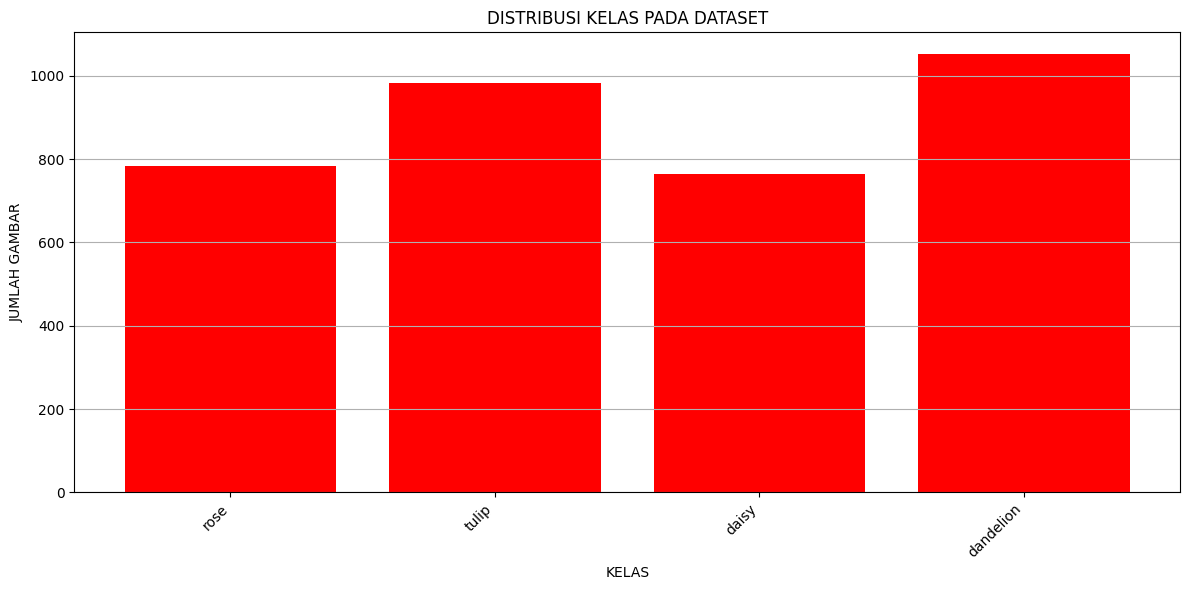

In [3]:
import matplotlib.pyplot as plt

# Visualisasi Distribusi Kelas
def plot_class_distribution(dataset_directory):
    classes = os.listdir(dataset_directory)
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(dataset_directory, cls)
        if os.path.isdir(class_path):
            class_counts[cls] = len(os.listdir(class_path))

    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='red')
    plt.xlabel('KELAS')
    plt.ylabel('JUMLAH GAMBAR')
    plt.title('DISTRIBUSI KELAS PADA DATASET')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Menampilkan distribusi kelas
dataset_directory = 'flowers_dataset/flowers'
plot_class_distribution(dataset_directory)

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Augmentasi dan scaling gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% untuk validasi
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    'flowers_dataset/flowers',
    target_size=(150, 150),  # Handling resolusi gambar yang tidak seragam
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Bagian training
)

# Generator untuk data validasi
validation_generator = train_datagen.flow_from_directory(
    'flowers_dataset/flowers',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Bagian validasi
)

# Distribusi kelas berdasarkan dataset karena tidak seimbang dengan oversampling
class_weights = {
    0: 1052/984,  # Tulip (jumlah gambar 984)
    1: 1052/764,  # Daisy (jumlah gambar 764)
    2: 1.0,       # Dandelion (jumlah gambar 1052, baseline)
    3: 1052/784   # Rose (jumlah gambar 784)
}

Found 2870 images belonging to 4 classes.
Found 714 images belonging to 4 classes.


In [5]:
# Callback untuk menghentikan training ketika val_accuracy > 90%
class AccuracyThresholdStopping(Callback):
    def __init__(self, threshold=0.90, monitor='val_accuracy'):
        super(AccuracyThresholdStopping, self).__init__()
        self.threshold = threshold
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None and current >= self.threshold:
            print(f"\nEpoch {epoch+1}: {self.monitor} has reached {current:.2f}, stopping training.")
            self.model.stop_training = True

# Callback untuk menyimpan model terbaik
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

from tensorflow.keras.applications import Xception #transfer learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Muat model transfer learning tanpa lapisan klasifikasi akhir dan tanpa bobot atas
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Bekukan lapisan-lapisan pada model transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan lapisan klasifikasi kustom di atas model transfer learning
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 kelas bunga

# Buat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Callback untuk menghentikan training jika tidak ada peningkatan selama 15 epoch
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Compile model dengan learning rate kecil
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[checkpoint,early_stop, AccuracyThresholdStopping(threshold=0.90)]
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 61s 477ms/step - accuracy: 0.5850 - loss: 1.2024 - val_accuracy: 0.8095 - val_loss: 0.5009
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 362ms/step - accuracy: 0.7700 - loss: 0.6918 - val_accuracy: 0.8109 - val_loss: 0.4535
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 343ms/step - accuracy: 0.8004 - loss: 0.5890 - val_accuracy: 0.8459 - val_loss: 0.4120
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 290ms/step - accuracy: 0.8379 - loss: 0.5163 - val_accuracy: 0.8291 - val_loss: 0.4313
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.8200 - loss: 0.5382 - val_accuracy: 0.8305 - val_loss: 0.4601
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.8412 - loss: 0.4882 - val_accuracy: 0.8389 - val_loss: 0.4154
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 0.8425 - loss: 0.4781 - val_accuracy: 0.8389 - val_loss: 0.4111
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 0.8714 - loss: 0.4130 - val_accuracy

In [6]:
from tensorflow.keras.models import load_model

# Muat model terbaik
best_model = load_model('best_model.keras')

# Evaluasi model terbaik
loss, accuracy = best_model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.8630 - loss: 0.3936
Validation Loss: 0.37486928701400757
Validation Accuracy: 0.8515406250953674


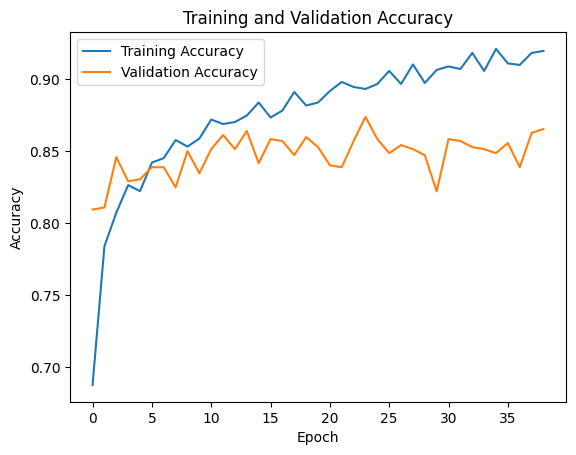

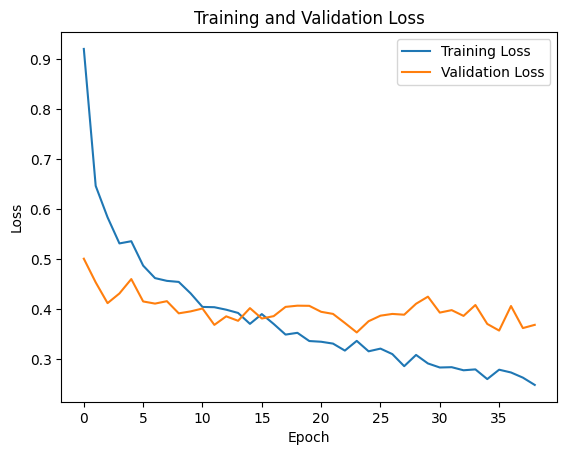

In [7]:
# Plot Akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
!pip install tensorflowjs
import tensorflow as tf
import tensorflowjs as tfjs

# Menyimpan model dalam format SavedModel
model.export('saved_model/flowers_model') # Use model.export to save in SavedModel format

# Mengonversi model Keras ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Mengonversi dan menyimpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
Saved artifact at 'saved_model/flowers_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138187016836496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138187015370736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138187015371440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138187015371616: Tenso

failed to lookup keras version from the file,
    this is likely a weight only file


In [9]:
from google.colab import files

# Unduh file model TFLite
files.download('model.tflite')

# Unduh file SavedModel (biasanya berupa folder, jadi harus dijadikan zip dulu)
!zip -r saved_model.zip saved_model/
files.download('saved_model.zip')

# Unduh model TensorFlow.js (jika berupa folder, zip dulu)
!zip -r tfjs_model.zip tfjs_model/
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: saved_model/ (stored 0%)
  adding: saved_model/flowers_model/ (stored 0%)
  adding: saved_model/flowers_model/saved_model.pb (deflated 91%)
  adding: saved_model/flowers_model/fingerprint.pb (stored 0%)
  adding: saved_model/flowers_model/variables/ (stored 0%)
  adding: saved_model/flowers_model/variables/variables.index (deflated 79%)
  adding: saved_model/flowers_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/flowers_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard12of45.bin (deflated 7%)
  adding: tfjs_model/group1-shard16of45.bin (deflated 7%)
  adding: tfjs_model/group1-shard10of45.bin (deflated 7%)
  adding: tfjs_model/group1-shard36of45.bin (deflated 8%)
  adding: tfjs_model/group1-shard11of45.bin (deflated 7%)
  adding: tfjs_model/group1-shard44of45.bin (deflated 8%)
  adding: tfjs_model/group1-shard9of45.bin (deflated 7%)
  adding: tfjs_model/group1-shard32of45.bin (deflated 8%)
  adding: tfjs_model/group1-shard7of45.bin (deflated 7%)
  adding: tfjs_model/group1-shard21of45.bin (deflated 8%)
  adding: tfjs_model/group1-shard45of45.bin (deflated 8%)
  adding: tfjs_model/group1-shard5of45.bin (deflated 7%)
  adding: tfjs_model/group1-shard30of45.bin (deflated 8%)
  adding: tfjs_model/group1-shard37of45.bin (deflated 8%)
  adding: tfjs_model/group1-shard4of45.bin (deflated 7%)
  adding: tfjs_model/group1-shard24of45.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>